In [6]:
print(" Welcome to my code ")

 Welcome to my code 


Code for generating RRC coefficients

In parameter section you can change the num_taps and add to the main.v file

coeffs[ 0] = -8'd11;
coeffs[ 1] = -8'd15;
coeffs[ 2] = -8'd18;
coeffs[ 3] = -8'd18;
coeffs[ 4] = -8'd14;
coeffs[ 5] = -8'd 6;
coeffs[ 6] =  8'd 6;
coeffs[ 7] =  8'd22;
coeffs[ 8] =  8'd39;
coeffs[ 9] =  8'd56;
coeffs[10] =  8'd73;
coeffs[11] =  8'd86;
coeffs[12] =  8'd94;
coeffs[13] =  8'd97;
coeffs[14] =  8'd94;
coeffs[15] =  8'd86;
coeffs[16] =  8'd73;
coeffs[17] =  8'd56;
coeffs[18] =  8'd39;
coeffs[19] =  8'd22;
coeffs[20] =  8'd 6;
coeffs[21] = -8'd 6;
coeffs[22] = -8'd14;
coeffs[23] = -8'd18;
coeffs[24] = -8'd18;
coeffs[25] = -8'd15;


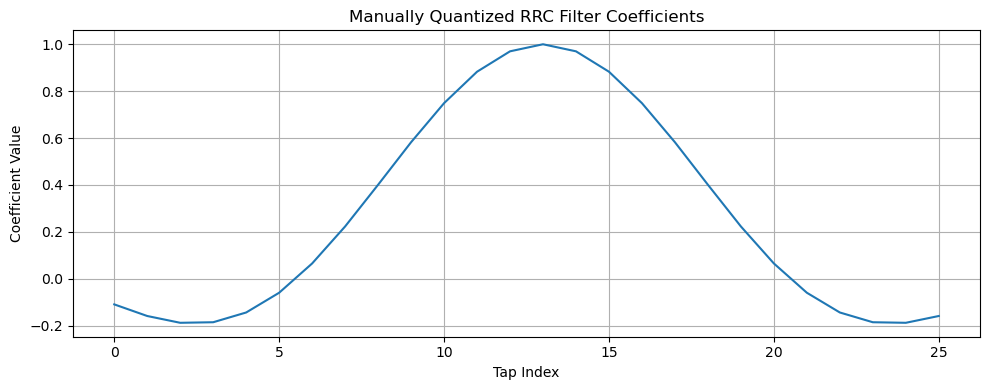

In [7]:
import numpy as np
import matplotlib.pyplot as plt

#__________________________________

# Parameters
beta = 0.25
Ts = 1/8
num_taps = 25

#________________________________________

# RRC function

def rrc_filter(beta, sps, num_taps):
    if num_taps % 2 == 0:
        raise ValueError("num_taps must be odd for symmetry")
    
    T = 1
    N = num_taps
    t = np.arange(-N//2, N//2 + 1)*Ts
    pi = np.pi

    h = np.zeros(len(t))
    for i in range(len(t)):
        if t[i] == 0.0:
            h[i] = 1.0 - beta + (4 * beta / pi)
        elif abs(t[i]) == T / (4 * beta):
            h[i] = (beta / np.sqrt(2)) * (
                ((1 + 2/pi) * np.sin(pi/(4*beta))) +
                ((1 - 2/pi) * np.cos(pi/(4*beta)))
            )
        else:
            h[i] = (np.sin(pi * t[i] * (1 - beta)) +
                    4 * beta * t[i] * np.cos(pi * t[i] * (1 + beta))) / \
                   (pi * t[i] * (1 - (4 * beta * t[i])**2))

    h = h / np.max(np.abs(h))  
    return h

#______________________________________________________

def quantize_to_8bit_signed(coeffs, scale_max=97):
    scaled = coeffs * scale_max
    quantized = np.round(scaled).astype(int)
    return quantized


#______________________________________________________


rrc_coeffs = rrc_filter(beta, Ts, num_taps)
quantized_coeffs = quantize_to_8bit_signed(rrc_coeffs)


for i, val in enumerate(quantized_coeffs):
    sign = '-' if val < 0 else ' '
    print(f"coeffs[{i:2}] = {sign}8'd{abs(val):2};")
    
    
#___________________________________________________________

plt.figure(figsize=(10, 4))
plt.plot(rrc_coeffs)  # No use_line_collection
plt.title("Manually Quantized RRC Filter Coefficients")
plt.xlabel("Tap Index")
plt.ylabel("Coefficient Value")
plt.grid(True)
plt.tight_layout()
plt.show()

#_______________________________________


Original Coefficients

Code for Updating the testbench

you could changed the total_cycle depends on yours

In [8]:
import random
import csv


#----------------------------------------------------------------------------------------------------
def generate_testbench(filename="tb.v", csv_filename="tb_inputs.csv", total_cycles=100, seed=42):
    random.seed(seed)

    with open(csv_filename, "w", newline="") as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(["cycle", "serial_in_bit", "symbol_edge_detect", "in_valid"])

        with open(filename, "w") as f:
            f.write("""module tb;

    reg clk;
    reg serial_in_bit;
    reg symbol_edge_detect;
    reg rst;
    reg in_valid;
    wire signed [15:0] real_out;
    wire signed [15:0] imag_out;
    wire out_valid;

    // DUT instantiation
    rrc_fir r_f (
        .clk(clk),
        .serial_in_bit(serial_in_bit),
        .symbol_edge_detect(symbol_edge_detect),
        .rst(rst),
        .in_valid(in_valid),
        .real_out(real_out),
        .imag_out(imag_out),
        .out_valid(out_valid)
    );

    // Clock generation
    always #1 clk = ~clk;

    integer i;

    initial begin
        clk = 0;
        rst = 1;
        serial_in_bit = 0;
        symbol_edge_detect = 0;
        in_valid = 0;

        // Apply reset
        #10;
        rst = 0;
""")


            # Stimulus loop
            for i in range(total_cycles):
                delay = 40
                serial_bit = random.randint(0, 1)
                edge = i % 2
                in_valid = 1 if i >= 10 else 0  # first 10 cycles invalid

                # Write input to CSV
                writer.writerow([i, serial_bit, edge, in_valid])

                # Write input to Verilog file
                f.write(f"""
        #{delay};
        serial_in_bit = {serial_bit};
        symbol_edge_detect = {edge};
        in_valid = {in_valid};
""")

            f.write("""
        $finish;
    end
endmodule
""")
            
#---------------------------------------------------------------------------------

generate_testbench()


Code for Validation

In [10]:
import csv
import math
import numpy as np


#__________________________________________
# FIR coefficients from Verilog (int8)
coeffs = quantized_coeffs
print(coeffs)
#__________________________________________
# Parameters
BITS_PER_SYMBOL = 4
desired_qam = 16
available_qam = 256
SPS = 4  # Samples Per Symbol

#______________________________________

# Load input bits and in_valid signals from CSV
serial_bits = []
in_valids = []

with open("tb_inputs.csv", newline='') as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
        serial_bits.append(int(row['serial_in_bit']))
        in_valids.append(int(row['in_valid']))

# Collect 4-bit symbols (reverse the 4 bits before forming symbol)
bit_buffer = []
collected_symbols = []

for bit, valid in zip(serial_bits, in_valids):
    if valid == 1:
        bit_buffer.append(bit)
        if len(bit_buffer) == BITS_PER_SYMBOL:
            reversed_bits = bit_buffer[::-1]  # Reverse the 4 bits
            symbol_val = 0
            for b in reversed_bits:
                symbol_val = (symbol_val << 1) | b
            collected_symbols.append(symbol_val)
            bit_buffer = []


# Map to QAM angles, scaled to ±127 for 8-bit LUTs
real_parts = [int(round(127 * math.cos(2 * math.pi * sym / desired_qam))) for sym in collected_symbols]
imag_parts = [int(round(127 * math.sin(2 * math.pi * sym / desired_qam))) for sym in collected_symbols]

# Upsample with SPS-1 zeros
def upsample(signal, sps):
    upsampled = []
    for val in signal:
        upsampled.append(val)
        upsampled.extend([0] * (sps - 1))
    return upsampled

real_upsampled = upsample(real_parts, SPS)
imag_upsampled = upsample(imag_parts, SPS)

# Integer convolution (Verilog-style filtering)
real_conv = np.convolve(real_upsampled, coeffs.astype(np.int16), mode='same')
imag_conv = np.convolve(imag_upsampled, coeffs.astype(np.int16), mode='same')

# Display results
print("Collected symbols (0-15):", collected_symbols)
print("\nReal parts of symbols:", real_parts)
print("Imag parts of symbols:", imag_parts)

print("\nFiltered Real output (convolution):")
print(real_conv)

print("\nFiltered Imag output (convolution):")
print(imag_conv)


for a, b in zip(real_conv,imag_conv):
    print(a, b)


#_________________________________________________________

[-11 -15 -18 -18 -14  -6   6  22  39  56  73  86  94  97  94  86  73  56
  39  22   6  -6 -14 -18 -18 -15]
Collected symbols (0-15): [0, 4, 3, 7, 2, 13, 5, 13, 0, 1, 15, 6, 1, 14, 2, 14, 4, 7, 9, 7, 2, 8]

Real parts of symbols: [127, 0, 49, -117, 90, 49, -49, 49, 127, 117, 117, -90, 117, 90, 90, 90, 0, -117, -117, -117, 90, -127]
Imag parts of symbols: [0, 127, 117, 49, 90, -117, 117, -117, 0, 49, -49, 90, 49, -90, 90, -90, 127, 49, -49, 49, 90, 0]

Filtered Real output (convolution):
[ 12539  13780  14338  14106  11830   9208   6208   2814   -994  -3836
  -6055  -7036  -6344  -5029  -1341    716   2271   4187   5612   6538
   5598   4817   4185   2878    463   -567  -1722    146   1731   5020
   9876  13644  18254  21822  25398  27138  25981  24239  21160  17950
  13281   9312   6295   3564    810   -123   1926   3150   4284   7002
  11340  14076  16605  18567  21393  21654  22149  21213  19008  17460
  16389  13932  12114   7632   3852   -945  -4887 -10170 -15993 -20439
 -23121 -259